In [52]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import pickle
from glob import glob
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [53]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
    

GPU is available


In [54]:
train_path = "../train/train"
# The glob module finds all the pathnames matching a specified pattern
train_pkl_lst = glob(os.path.join(train_path, '*'))
with open(train_pkl_lst[1], 'rb') as f:
    training_sample = pickle.load(f)

# LSTM

In [55]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(MyLSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        h_t, c_t = self.init_hidden(batch_size)

        #print(x.size())
        #print(x.size(-1))
        # Passing in the input and hidden state into the model and obtaining outputs
        out, (h_t, c_t) = self.lstm(x, (h_t, c_t))
        
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, h_t
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        c_0 =  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)       
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return h_0, c_0

In [6]:
# Autogressive vs. direct mapping
# Batch Norm? 

# Dataset

In [56]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    
    def __init__(self, 
                 data_path,
                 sample_indices):
        super(ArgoverseDataset, self).__init__()
        
        self.data_path = data_path
        self.sample_indices = sample_indices
        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.sample_indices)

    def __getitem__(self, idx):
        
        # Load one scene
        pkl_path = self.pkl_list[self.sample_indices[idx]]
        with open(pkl_path, 'rb') as f:
            scene = pickle.load(f)
            
        # the index of agent to be predicted 
        pred_id = np.where(scene["track_id"] == scene['agent_id'])[0][0]
        
        # input: p_in & v_in; output: p_out
        inp_scene = np.dstack([scene['p_in'], scene['v_in']])
        out_scene = np.dstack([scene['p_out'], scene['v_out']])
        
        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        
        # Normalize by vectors
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        out = (out_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        dat = np.concatenate((inp, out), axis=0)
        
        train_data = []
        window_size = 20
        interval = 7
        for i in range(0, len(dat), interval):
            #print(len(dat[i:i+input_length]))
            if i + window_size < len(dat): 
                train_data.append(dat[i:i+window_size])
            
        #print(len(train_data))
        #print(train_data)
        
        input_seq = []
        target_seq = []
        for i in range(len(train_data)):
            input_seq.append(train_data[i][:-1])
            target_seq.append(train_data[i][1:])
        
        #print(input_seq)
        
        input_seq = np.array(input_seq, dtype=np.float32)
        target_seq = np.array(target_seq, dtype=np.float32)
        
        #print(input_seq.shape)
        #print(target_seq.shape)
        
        # Convert to float torch tensor
        #return torch.from_numpy(inp).float(), torch.from_numpy(out).float() #torch.from_numpy(out[:,:2]).float()
        return torch.from_numpy(input_seq).float(), torch.from_numpy(target_seq).float()

In [36]:
training_sample['p_out'].shape

(60, 30, 2)

In [37]:
training_sample['v_out'].shape

(60, 30, 2)

In [5]:
# Try different ways of normalization
# Leverage other features. 

# Hyperparameter

In [6]:
# Grid/Random Search

In [57]:
# batch_size = 64
interval = 7 # sampling interval for LSTM
window_size = 20 # number of timesteps to take as input
batch_size = 512
#in_dim = 19*4 # MLP
#out_dim = 4 #30*2 # MLP
input_size = 4 # LSTM
output_size = 4 # LSTM (has to match input_size)
hidden_dim = 128 #256 #128 #32 #128
num_layers = 2 #1 #3
learning_rate = 0.01
decay_rate = 0.95
num_epoch = 1000

# Data Loader

In [58]:
train_path = "../train/train"

# total number of scenes
indices = np.arange(0, 205942)

# train-valid split
np.random.shuffle(indices)
train_indices = indices[:180000]
valid_indices = indices[180000:]

# define datasets
train_set = ArgoverseDataset(train_path, train_indices)
valid_set = ArgoverseDataset(train_path, valid_indices)

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)

In [59]:
len(train_set)

180000

In [80]:
# train_set[0]

In [60]:
len(train_loader)

352

# Model, Loss Function and Optimizer

In [61]:
# # RNN, LSTM, 1dCNN, Transformer
# model = MLPNet(in_dim = in_dim, 
#                out_dim = out_dim,
#                hidden_dim = hidden_dim, 
#                num_layers = num_layers).to(device) # move model to gpu 

model = MyLSTM(input_size=input_size, output_size=output_size, hidden_dim=hidden_dim, n_layers=num_layers).to(device)

# Adaptive Moment Estimation computes adaptive learning rates for each parameter. 
# Compute the decaying averages of past and past squared gradients. 

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=decay_rate)  # stepwise learning rate decay
loss_fun = nn.MSELoss()

In [9]:
model.load_state_dict(torch.load('baseline.pt'))

<All keys matched successfully>

In [118]:
# train_path = "./train/train/"
# train_pkl_list = glob(os.path.join(train_path, '*'))
# train_pkl_list.sort()

# train_preds = []
# for idx in range(3):
#     with open(train_pkl_list[idx], 'rb') as f:
#         train_sample = pickle.load(f)
#         pred_id = np.where(train_sample["track_id"] == train_sample['agent_id'])[0][0]
#         inp_scene = np.dstack([train_sample['p_in'], train_sample['v_in']])

#         # Normalization 
#         min_vecs = np.min(inp_scene, axis = (0,1))
#         max_vecs = np.max(inp_scene, axis = (0,1))
        
#         inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
#         inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

#         preds = model(inp).cpu().data.numpy()
        
#         # De-Normalization ! 
#         preds = preds * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
#         train_preds.append(preds)

# Training

In [171]:
for inp, tgt in train_loader:
    print(inp.shape)
    print(tgt.shape)
    print(inp.view(-1, window_size-1, 4).size()) 
    print(inp[0, 0, :, :])
    break
        

torch.Size([512, 5, 19, 4])
torch.Size([512, 5, 19, 4])
torch.Size([2560, 19, 4])
tensor([[1.0000, 1.0000, 0.0566, 0.0473],
        [0.9998, 0.9996, 0.0643, 0.0610],
        [0.9995, 0.9992, 0.0543, 0.0229],
        [0.9993, 0.9988, 0.1135, 0.1166],
        [0.9991, 0.9984, 0.0722, 0.0608],
        [0.9989, 0.9981, 0.1136, 0.1087],
        [0.9987, 0.9977, 0.0845, 0.0779],
        [0.9984, 0.9973, 0.0762, 0.0627],
        [0.9982, 0.9969, 0.0633, 0.0508],
        [0.9980, 0.9965, 0.0501, 0.0407],
        [0.9978, 0.9962, 0.1454, 0.1404],
        [0.9975, 0.9957, 0.0430, 0.0333],
        [0.9973, 0.9954, 0.1270, 0.1274],
        [0.9971, 0.9950, 0.0749, 0.0670],
        [0.9969, 0.9946, 0.0619, 0.0524],
        [0.9966, 0.9942, 0.0747, 0.0485],
        [0.9964, 0.9938, 0.0602, 0.0563],
        [0.9962, 0.9935, 0.1179, 0.1185],
        [0.9959, 0.9930, 0.0306, 0.0269]])


In [62]:
def train_epoch(train_loader, model, optimizer, loss_function):

    train_mse = []
    for inp, tgt in tqdm(train_loader):
        
        inp = inp.view(-1, window_size-1, 4)
        tgt = tgt.view(-1, window_size-1, 4)
        
        #print(inp.size())
        
        inp = inp.to(device)
        tgt = tgt.to(device)
        
        output, hidden = model(inp)
        output = output.to(device)
        #print(output.shape)
        #print(hidden.shape)
        #print(tgt.view(-1, 4).size())
        
        loss = loss_function(output, tgt.view(-1, 4))
        train_mse.append(loss.item()) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_mse = round(np.sqrt(np.mean(train_mse)),5)
    
    return train_mse

def eval_epoch(valid_loader, model, loss_function):
    
    valid_mse = []
    #preds = []
    #trues = []
    
    with torch.no_grad():
        for inp, tgt in valid_loader:
            
            inp = inp.view(-1, window_size-1, 4)
            tgt = tgt.view(-1, window_size-1, 4)
            
            inp = inp.to(device)
            tgt = tgt.to(device)
            
            loss = 0
            output, hidden = model(inp)
            output = output.to(device)
                    
            loss = loss_function(output, tgt.view(-1, 4))
            
            #preds.append(pred.cpu().data.numpy())
            #trues.append(tgt.cpu().data.numpy())
            
            valid_mse.append(loss.item())
            
        #preds = np.concatenate(preds, axis = 0)  
        #trues = np.concatenate(trues, axis = 0)  
        valid_mse = round(np.sqrt(np.mean(valid_mse)), 5)
    return valid_mse#, preds, trues


In [14]:
# Learning Rate Decay
# Dropout
# L1/L2 Regulization

In [63]:
len(train_pkl_lst)

205942

 44%|████▍     | 155/352 [01:41<01:56,  1.70it/s]


 88%|████████▊ | 309/352 [03:31<00:26,  1.59it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.17654]
0.12472
Epoch 1 | T: 4.65 | Train RMSE: 0.17654 | Valid RMSE: 0.12472


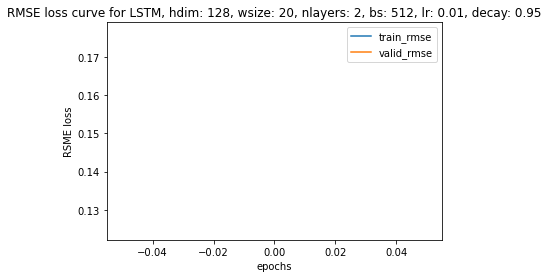

 44%|████▍     | 154/352 [02:00<02:03,  1.60it/s]


 88%|████████▊ | 308/352 [03:50<00:33,  1.31it/s]


100%|██████████| 352/352 [04:19<00:00,  1.36it/s]


[0.17654, 0.11337]
0.11275
Epoch 2 | T: 4.97 | Train RMSE: 0.11337 | Valid RMSE: 0.11275


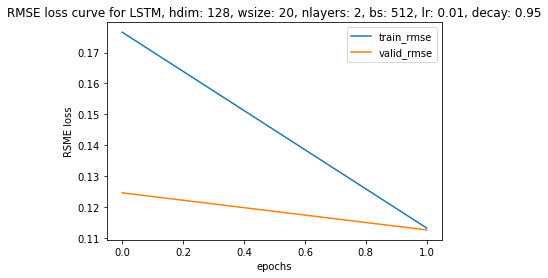

 44%|████▍     | 154/352 [01:58<02:06,  1.57it/s]


 88%|████████▊ | 308/352 [03:34<00:25,  1.76it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.17654, 0.11337, 0.11083]
0.11246
Epoch 3 | T: 4.97 | Train RMSE: 0.11083 | Valid RMSE: 0.11246


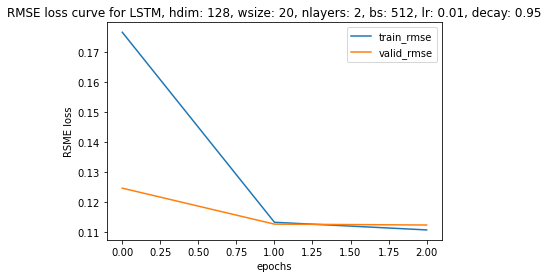

 44%|████▍     | 154/352 [01:56<02:06,  1.56it/s]


 88%|████████▊ | 308/352 [03:36<00:27,  1.61it/s]


100%|██████████| 352/352 [04:13<00:00,  1.39it/s]


[0.17654, 0.11337, 0.11083, 0.11029]
0.112
Epoch 4 | T: 4.87 | Train RMSE: 0.11029 | Valid RMSE: 0.11200


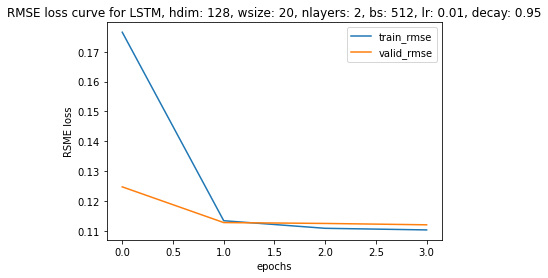

 44%|████▍     | 154/352 [01:42<01:59,  1.65it/s]


 88%|████████▊ | 308/352 [03:36<00:29,  1.51it/s]


100%|██████████| 352/352 [04:12<00:00,  1.40it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975]
0.11158
Epoch 5 | T: 4.69 | Train RMSE: 0.10975 | Valid RMSE: 0.11158


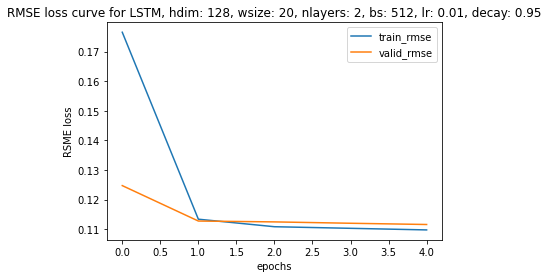

 44%|████▍     | 154/352 [01:53<01:52,  1.77it/s]


 88%|████████▊ | 308/352 [03:49<00:29,  1.51it/s]


100%|██████████| 352/352 [04:25<00:00,  1.32it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922]
0.11059
Epoch 6 | T: 4.95 | Train RMSE: 0.10922 | Valid RMSE: 0.11059


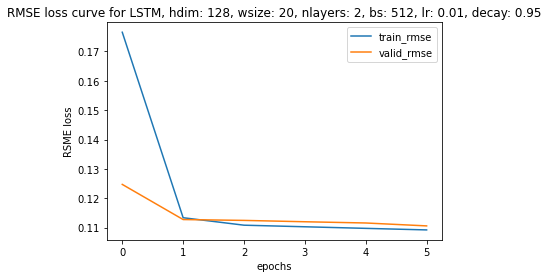

 44%|████▍     | 154/352 [02:01<01:59,  1.66it/s]


 88%|████████▊ | 308/352 [03:50<00:27,  1.62it/s]


100%|██████████| 352/352 [04:27<00:00,  1.31it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872]
0.11027
Epoch 7 | T: 4.96 | Train RMSE: 0.10872 | Valid RMSE: 0.11027


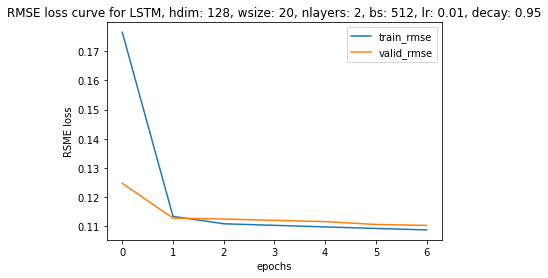

 44%|████▍     | 154/352 [01:53<01:54,  1.72it/s]


 88%|████████▊ | 308/352 [03:35<00:24,  1.80it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837]
0.10992
Epoch 8 | T: 4.71 | Train RMSE: 0.10837 | Valid RMSE: 0.10992


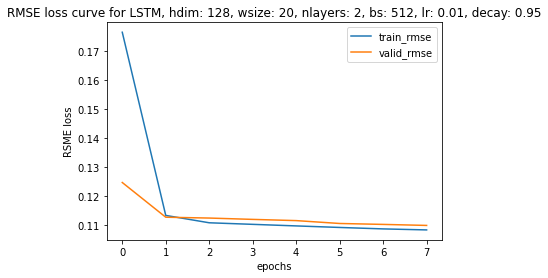

 44%|████▍     | 154/352 [01:50<01:57,  1.69it/s]


 88%|████████▊ | 308/352 [03:26<00:25,  1.71it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806]
0.10996
Epoch 9 | T: 4.53 | Train RMSE: 0.10806 | Valid RMSE: 0.10996


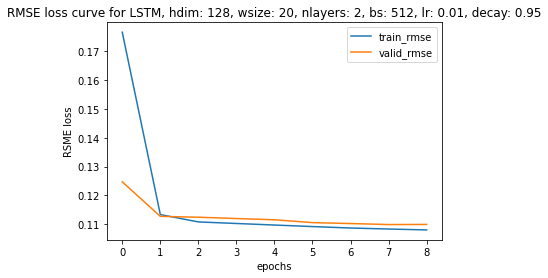

 44%|████▍     | 154/352 [01:51<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [03:40<00:26,  1.69it/s]


100%|██████████| 352/352 [04:14<00:00,  1.38it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773]
0.10997
Epoch 10 | T: 4.72 | Train RMSE: 0.10773 | Valid RMSE: 0.10997


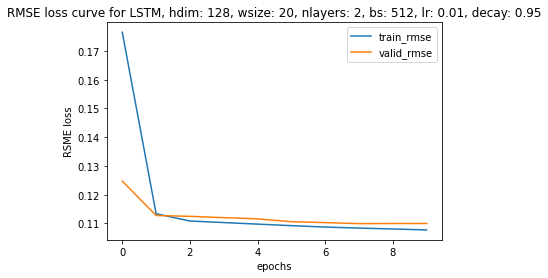

 44%|████▍     | 154/352 [01:50<01:54,  1.73it/s]


 88%|████████▊ | 308/352 [03:36<00:27,  1.60it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076]
0.10941
Epoch 11 | T: 4.71 | Train RMSE: 0.10760 | Valid RMSE: 0.10941


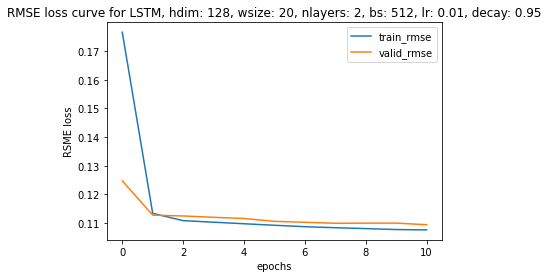

 44%|████▍     | 154/352 [01:56<03:08,  1.05it/s]


 88%|████████▊ | 308/352 [03:32<00:27,  1.59it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074]
0.11008
Epoch 12 | T: 4.59 | Train RMSE: 0.10740 | Valid RMSE: 0.11008


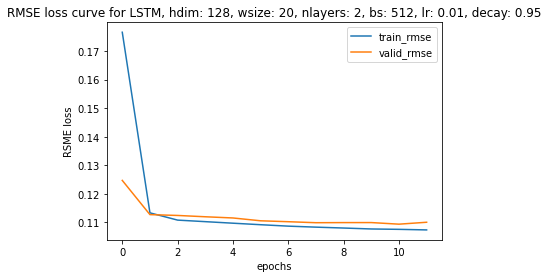

 44%|████▍     | 154/352 [01:55<01:56,  1.69it/s]


 88%|████████▊ | 308/352 [03:39<00:24,  1.79it/s]


100%|██████████| 352/352 [04:16<00:00,  1.37it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712]
0.10898
Epoch 13 | T: 4.73 | Train RMSE: 0.10712 | Valid RMSE: 0.10898


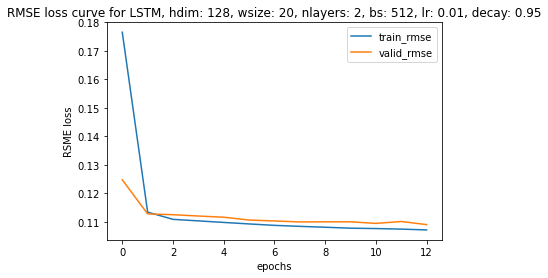

 44%|████▍     | 154/352 [01:56<01:50,  1.78it/s]


 88%|████████▊ | 308/352 [03:40<00:26,  1.65it/s]


100%|██████████| 352/352 [04:05<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697]
0.10897
Epoch 14 | T: 4.74 | Train RMSE: 0.10697 | Valid RMSE: 0.10897


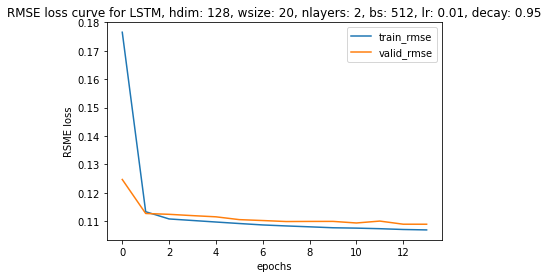

 44%|████▍     | 154/352 [01:52<01:58,  1.67it/s]


 88%|████████▊ | 308/352 [03:26<00:25,  1.74it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068]
0.10873
Epoch 15 | T: 4.58 | Train RMSE: 0.10680 | Valid RMSE: 0.10873


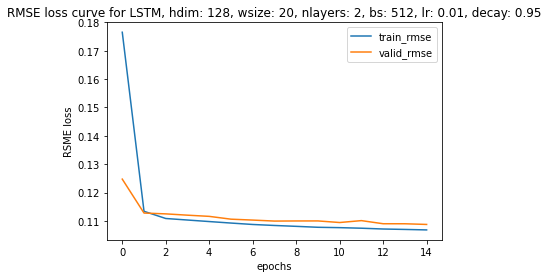

 44%|████▍     | 154/352 [01:45<01:44,  1.89it/s]


 88%|████████▊ | 308/352 [03:33<00:24,  1.82it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665]
0.10872
Epoch 16 | T: 4.57 | Train RMSE: 0.10665 | Valid RMSE: 0.10872


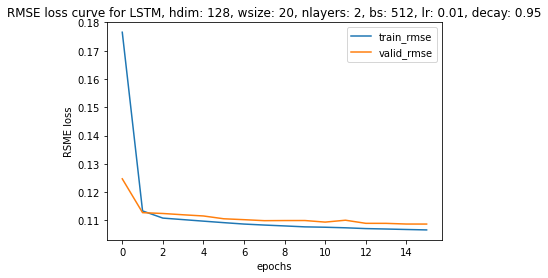

 44%|████▍     | 154/352 [01:56<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [03:36<02:20,  3.18s/it]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657]
0.10868
Epoch 17 | T: 4.72 | Train RMSE: 0.10657 | Valid RMSE: 0.10868


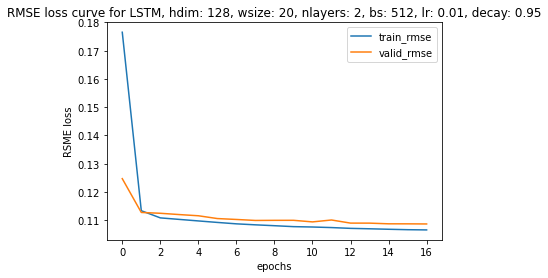

 44%|████▍     | 154/352 [01:43<01:51,  1.78it/s]


 88%|████████▊ | 308/352 [03:26<00:26,  1.68it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641]
0.10861
Epoch 18 | T: 4.49 | Train RMSE: 0.10641 | Valid RMSE: 0.10861


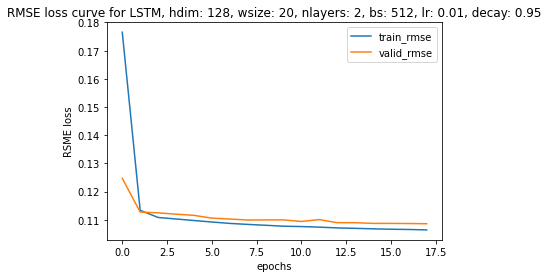

 44%|████▍     | 154/352 [01:56<01:50,  1.80it/s]


 88%|████████▊ | 308/352 [03:40<00:27,  1.61it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632]
0.10889
Epoch 19 | T: 4.76 | Train RMSE: 0.10632 | Valid RMSE: 0.10889


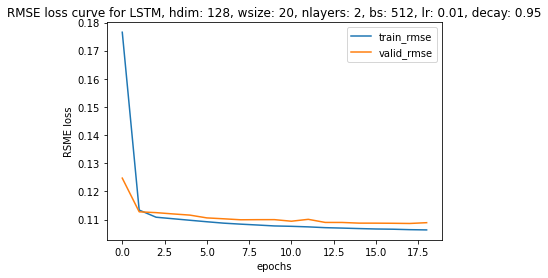

 44%|████▍     | 154/352 [01:50<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [03:19<00:24,  1.81it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627]
0.10858
Epoch 20 | T: 4.44 | Train RMSE: 0.10627 | Valid RMSE: 0.10858


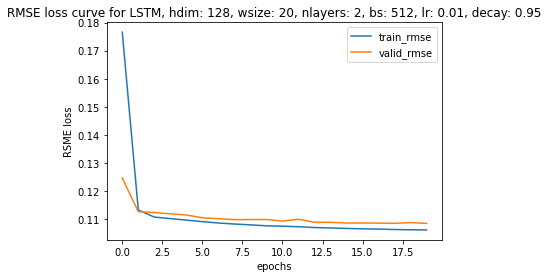

 44%|████▍     | 154/352 [01:51<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:32<00:23,  1.85it/s]


100%|██████████| 352/352 [03:55<00:00,  1.50it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621]
0.10842
Epoch 21 | T: 4.56 | Train RMSE: 0.10621 | Valid RMSE: 0.10842


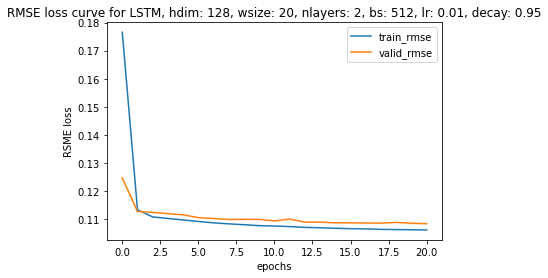

 44%|████▍     | 154/352 [01:51<01:53,  1.74it/s]


 88%|████████▊ | 308/352 [03:27<00:23,  1.87it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604]
0.10858
Epoch 22 | T: 4.52 | Train RMSE: 0.10604 | Valid RMSE: 0.10858


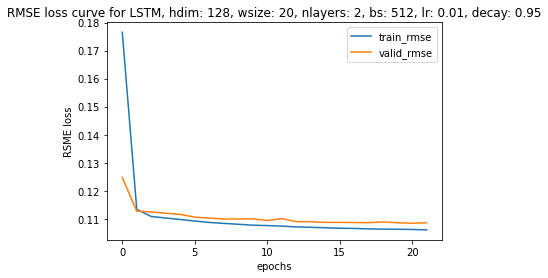

 44%|████▍     | 154/352 [01:46<01:56,  1.70it/s]


 88%|████████▊ | 308/352 [03:29<00:26,  1.65it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594]
0.10841
Epoch 23 | T: 4.55 | Train RMSE: 0.10594 | Valid RMSE: 0.10841


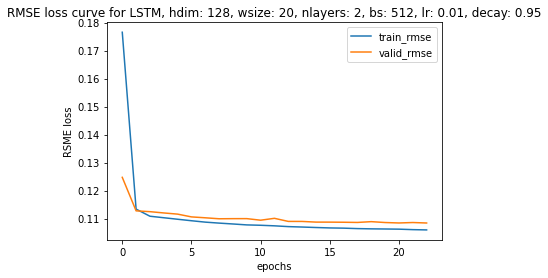

 44%|████▍     | 154/352 [01:53<02:05,  1.58it/s]


 88%|████████▊ | 308/352 [03:27<00:26,  1.63it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594]
0.1086
Epoch 24 | T: 4.47 | Train RMSE: 0.10594 | Valid RMSE: 0.10860


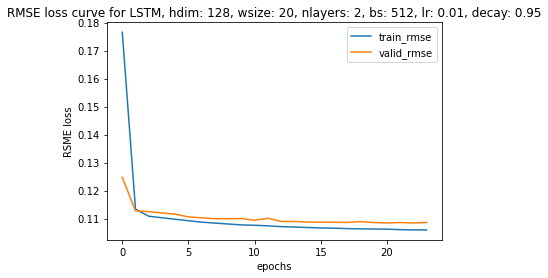

 44%|████▍     | 154/352 [01:50<01:47,  1.84it/s]


 88%|████████▊ | 308/352 [03:37<00:23,  1.84it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583]
0.10831
Epoch 25 | T: 4.70 | Train RMSE: 0.10583 | Valid RMSE: 0.10831


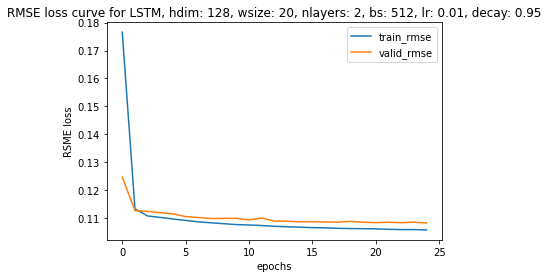

 44%|████▍     | 154/352 [01:53<01:42,  1.92it/s]


 88%|████████▊ | 308/352 [03:35<00:30,  1.45it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573]
0.10852
Epoch 26 | T: 4.66 | Train RMSE: 0.10573 | Valid RMSE: 0.10852


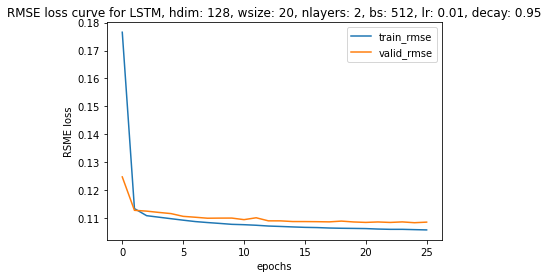

 44%|████▍     | 154/352 [01:37<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:19<00:26,  1.67it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562]
0.10851
Epoch 27 | T: 4.43 | Train RMSE: 0.10562 | Valid RMSE: 0.10851


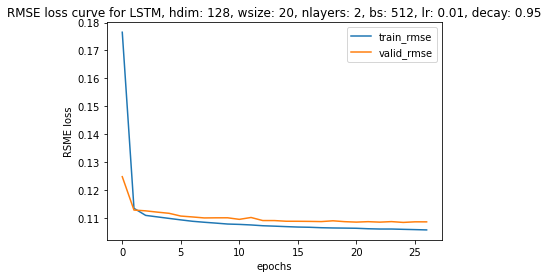

 44%|████▍     | 154/352 [01:47<01:41,  1.94it/s]


 88%|████████▊ | 308/352 [03:30<00:29,  1.50it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549]
0.10821
Epoch 28 | T: 4.55 | Train RMSE: 0.10549 | Valid RMSE: 0.10821


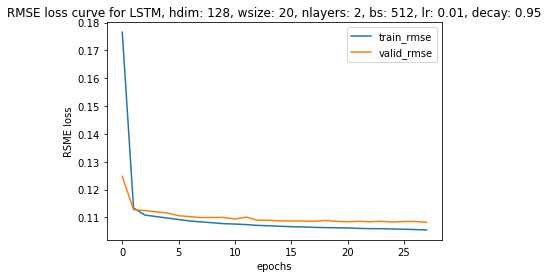

 44%|████▍     | 154/352 [01:36<01:48,  1.83it/s]


 88%|████████▊ | 308/352 [03:25<00:22,  1.92it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545]
0.10829
Epoch 29 | T: 4.44 | Train RMSE: 0.10545 | Valid RMSE: 0.10829


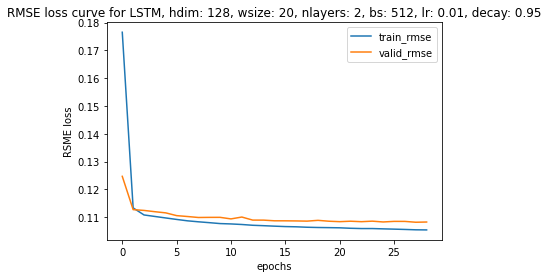

 44%|████▍     | 154/352 [01:49<01:44,  1.90it/s]


 88%|████████▊ | 308/352 [03:27<00:34,  1.27it/s]


100%|██████████| 352/352 [03:52<00:00,  1.52it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534]
0.10827
Epoch 30 | T: 4.49 | Train RMSE: 0.10534 | Valid RMSE: 0.10827


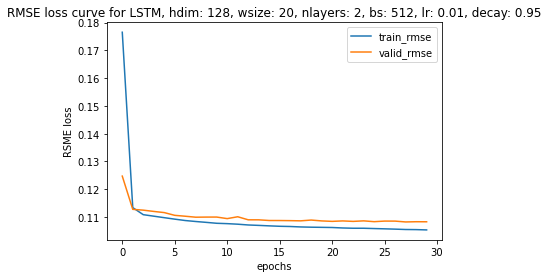

 44%|████▍     | 154/352 [01:40<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:26<00:24,  1.82it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531]
0.10854
Epoch 31 | T: 4.46 | Train RMSE: 0.10531 | Valid RMSE: 0.10854


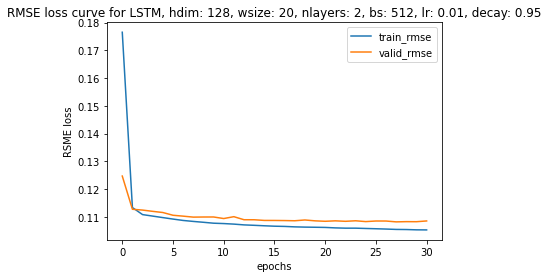

 44%|████▍     | 154/352 [01:52<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:32<00:51,  1.18s/it]


100%|██████████| 352/352 [03:57<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523]
0.10834
Epoch 32 | T: 4.62 | Train RMSE: 0.10523 | Valid RMSE: 0.10834


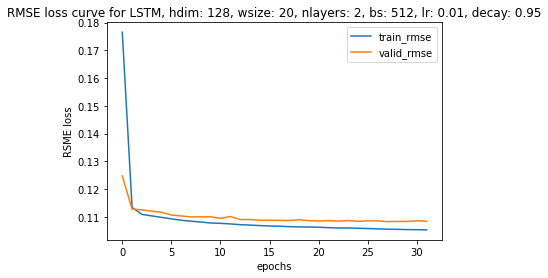

 44%|████▍     | 154/352 [01:43<01:52,  1.77it/s]


 88%|████████▊ | 308/352 [03:22<00:24,  1.77it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511]
0.10828
Epoch 33 | T: 4.43 | Train RMSE: 0.10511 | Valid RMSE: 0.10828


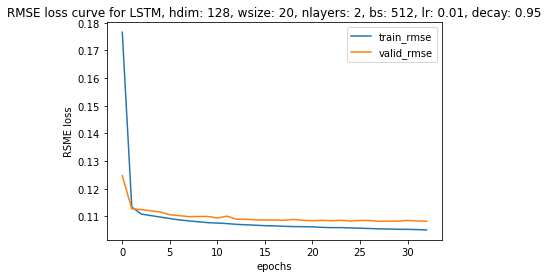

 44%|████▍     | 154/352 [01:50<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:37<00:30,  1.45it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499]
0.10814
Epoch 34 | T: 4.77 | Train RMSE: 0.10499 | Valid RMSE: 0.10814


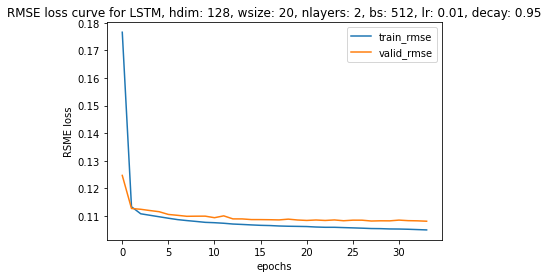

 44%|████▍     | 154/352 [01:48<02:04,  1.59it/s]


 88%|████████▊ | 308/352 [03:27<00:25,  1.71it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049]
0.10826
Epoch 35 | T: 4.43 | Train RMSE: 0.10490 | Valid RMSE: 0.10826


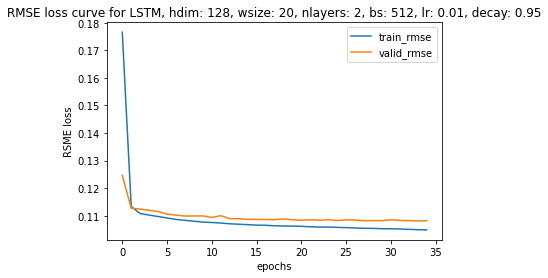

 44%|████▍     | 154/352 [01:51<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [03:41<00:26,  1.69it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483]
0.10827
Epoch 36 | T: 4.71 | Train RMSE: 0.10483 | Valid RMSE: 0.10827


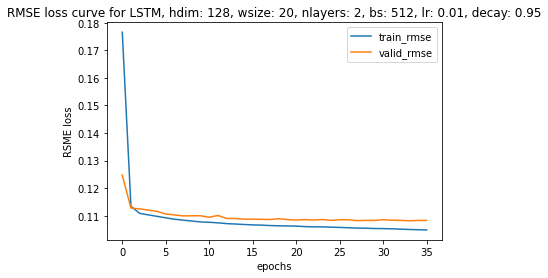

 44%|████▍     | 154/352 [01:47<01:55,  1.72it/s]


 88%|████████▊ | 308/352 [03:19<00:22,  1.94it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479]
0.10834
Epoch 37 | T: 4.29 | Train RMSE: 0.10479 | Valid RMSE: 0.10834


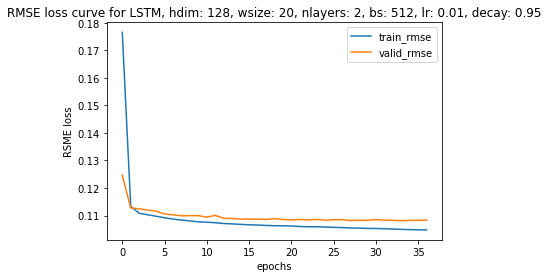

 44%|████▍     | 154/352 [01:56<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:38<00:25,  1.70it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467]
0.10819
Epoch 38 | T: 4.66 | Train RMSE: 0.10467 | Valid RMSE: 0.10819


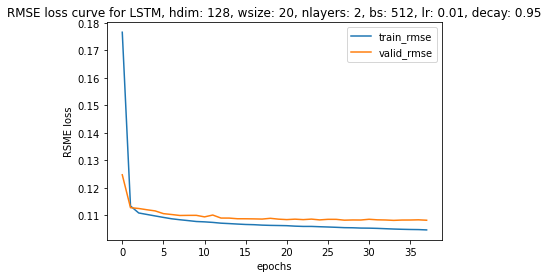

 44%|████▍     | 154/352 [01:50<01:52,  1.76it/s]


 88%|████████▊ | 308/352 [03:17<00:23,  1.87it/s]


100%|██████████| 352/352 [03:49<00:00,  1.54it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457]
0.10818
Epoch 39 | T: 4.22 | Train RMSE: 0.10457 | Valid RMSE: 0.10818


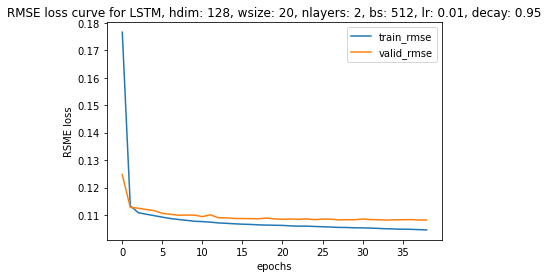

 44%|████▍     | 154/352 [01:59<01:38,  2.02it/s]


 88%|████████▊ | 308/352 [03:32<00:24,  1.76it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045]
0.10828
Epoch 40 | T: 4.58 | Train RMSE: 0.10450 | Valid RMSE: 0.10828


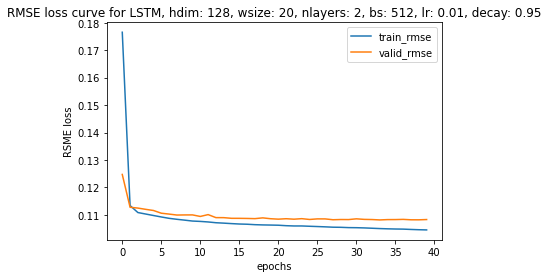

 44%|████▍     | 154/352 [01:39<01:44,  1.89it/s]


 88%|████████▊ | 308/352 [03:18<00:26,  1.68it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442]
0.10837
Epoch 41 | T: 4.43 | Train RMSE: 0.10442 | Valid RMSE: 0.10837


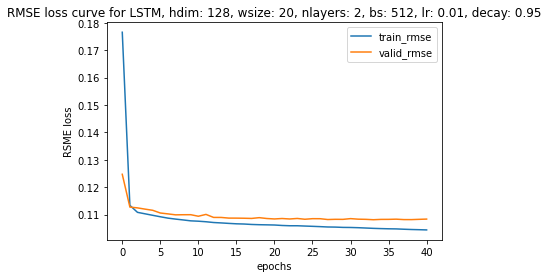

 44%|████▍     | 154/352 [01:48<01:53,  1.74it/s]


 88%|████████▊ | 308/352 [03:30<00:34,  1.27it/s]


100%|██████████| 352/352 [03:54<00:00,  1.50it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434]
0.10821
Epoch 42 | T: 4.54 | Train RMSE: 0.10434 | Valid RMSE: 0.10821


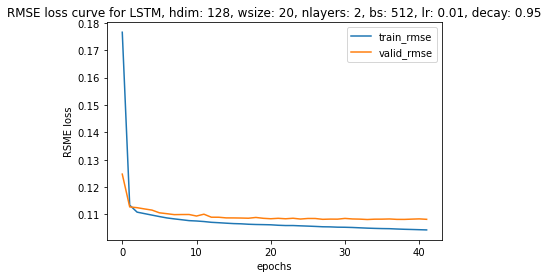

 44%|████▍     | 154/352 [01:40<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:25<00:26,  1.66it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428]
0.10844
Epoch 43 | T: 4.46 | Train RMSE: 0.10428 | Valid RMSE: 0.10844


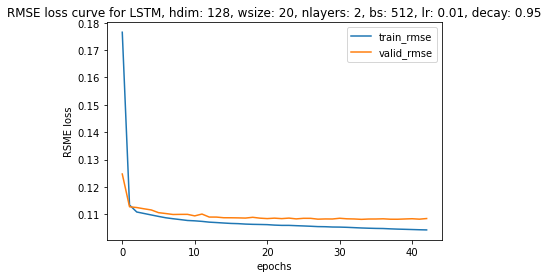

 44%|████▍     | 154/352 [01:46<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:17<00:23,  1.87it/s]


100%|██████████| 352/352 [03:50<00:00,  1.52it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422]
0.10832
Epoch 44 | T: 4.30 | Train RMSE: 0.10422 | Valid RMSE: 0.10832


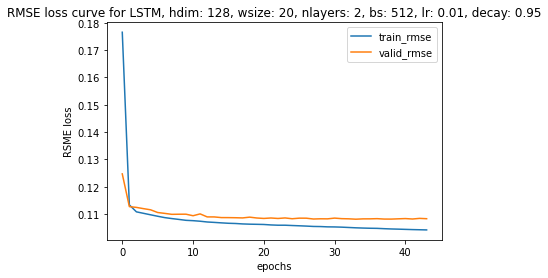

 44%|████▍     | 154/352 [01:56<03:44,  1.13s/it]


 88%|████████▊ | 308/352 [05:45<01:03,  1.45s/it]


100%|██████████| 352/352 [06:53<00:00,  1.17s/it]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413]
0.10832
Epoch 45 | T: 7.70 | Train RMSE: 0.10413 | Valid RMSE: 0.10832


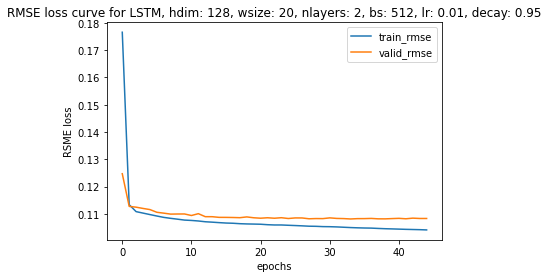

 44%|████▍     | 154/352 [02:58<03:40,  1.11s/it]


 88%|████████▊ | 308/352 [06:13<00:46,  1.05s/it]


100%|██████████| 352/352 [07:08<00:00,  1.22s/it]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406]
0.10846
Epoch 46 | T: 8.27 | Train RMSE: 0.10406 | Valid RMSE: 0.10846


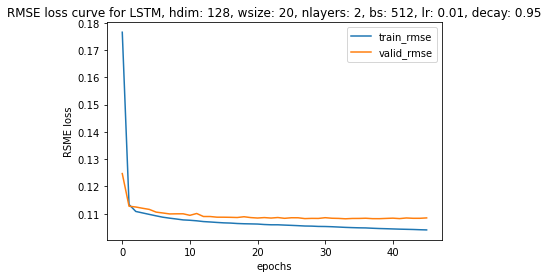

 44%|████▍     | 154/352 [03:00<04:09,  1.26s/it]


 88%|████████▊ | 308/352 [06:24<00:59,  1.36s/it]


100%|██████████| 352/352 [07:23<00:00,  1.26s/it]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104]
0.10846
Epoch 47 | T: 8.89 | Train RMSE: 0.10400 | Valid RMSE: 0.10846


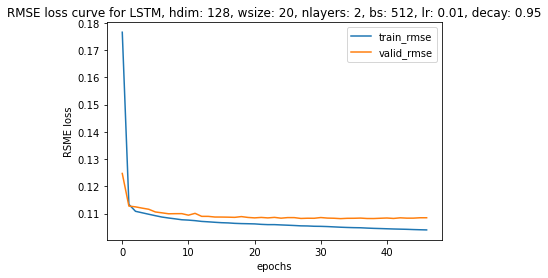

 44%|████▍     | 154/352 [02:41<03:25,  1.04s/it]


 88%|████████▊ | 308/352 [05:49<00:49,  1.13s/it]


100%|██████████| 352/352 [06:43<00:00,  1.15s/it]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393]
0.10841
Epoch 48 | T: 7.84 | Train RMSE: 0.10393 | Valid RMSE: 0.10841


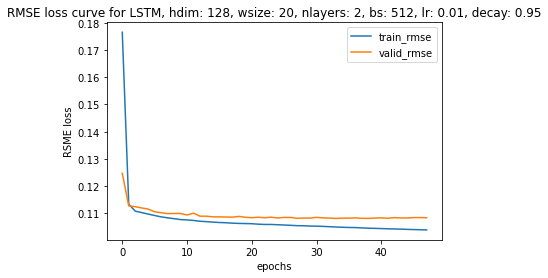

 44%|████▍     | 154/352 [02:15<03:26,  1.04s/it]


 88%|████████▊ | 308/352 [04:56<00:40,  1.08it/s]


100%|██████████| 352/352 [05:44<00:00,  1.02it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387]
0.10838
Epoch 49 | T: 6.59 | Train RMSE: 0.10387 | Valid RMSE: 0.10838


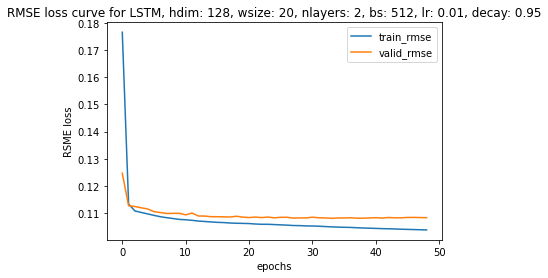

 44%|████▍     | 154/352 [02:03<02:25,  1.36it/s]


 88%|████████▊ | 308/352 [04:13<00:35,  1.22it/s]


100%|██████████| 352/352 [04:56<00:00,  1.19it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038]
0.10831
Epoch 50 | T: 5.63 | Train RMSE: 0.10380 | Valid RMSE: 0.10831


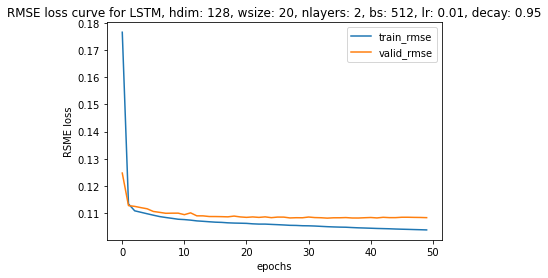

 44%|████▍     | 154/352 [01:52<02:06,  1.57it/s]


 88%|████████▊ | 308/352 [03:59<00:32,  1.34it/s]


100%|██████████| 352/352 [04:35<00:00,  1.28it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375]
0.10853
Epoch 51 | T: 5.02 | Train RMSE: 0.10375 | Valid RMSE: 0.10853


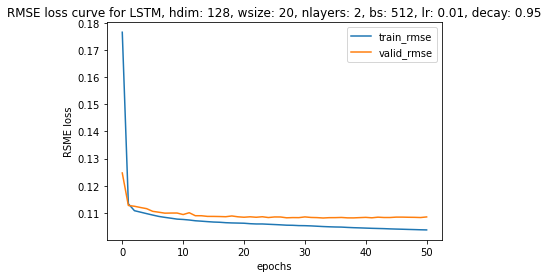

 44%|████▍     | 154/352 [02:07<02:07,  1.55it/s]


 88%|████████▊ | 308/352 [03:57<00:25,  1.73it/s]


100%|██████████| 352/352 [04:36<00:00,  1.27it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368]
0.10852
Epoch 52 | T: 4.98 | Train RMSE: 0.10368 | Valid RMSE: 0.10852


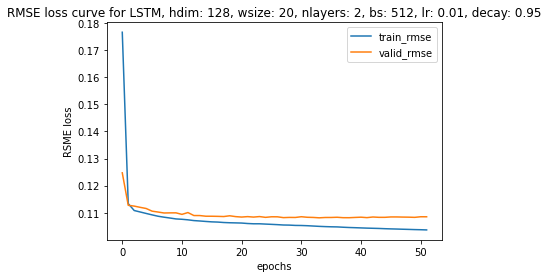

 44%|████▍     | 154/352 [01:54<01:48,  1.82it/s]


 88%|████████▊ | 308/352 [03:44<00:28,  1.57it/s]


100%|██████████| 352/352 [04:22<00:00,  1.34it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361]
0.10846
Epoch 53 | T: 4.88 | Train RMSE: 0.10361 | Valid RMSE: 0.10846


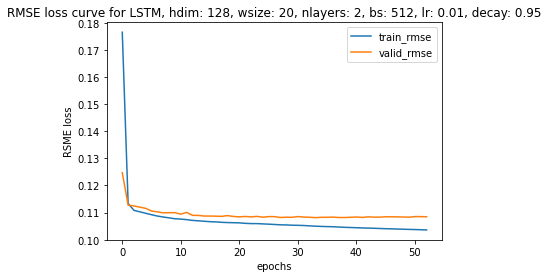

 44%|████▍     | 154/352 [01:47<01:47,  1.85it/s]


 88%|████████▊ | 308/352 [03:35<00:29,  1.50it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357]
0.10866
Epoch 54 | T: 4.66 | Train RMSE: 0.10357 | Valid RMSE: 0.10866


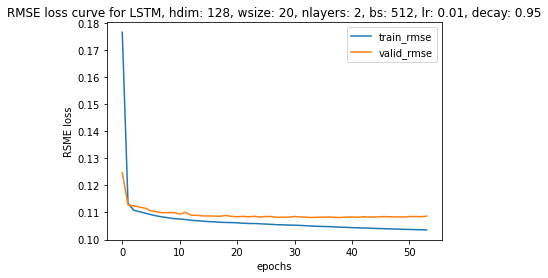

 44%|████▍     | 154/352 [01:38<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:31<00:25,  1.70it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353]
0.1085
Epoch 55 | T: 4.51 | Train RMSE: 0.10353 | Valid RMSE: 0.10850


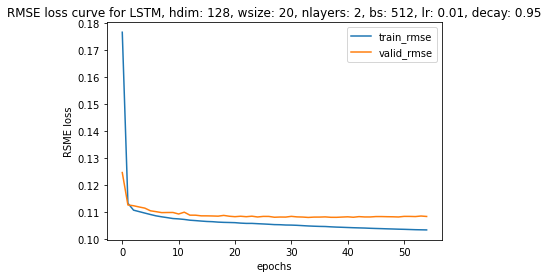

 44%|████▍     | 154/352 [01:52<01:45,  1.88it/s]


 88%|████████▊ | 308/352 [03:34<00:25,  1.72it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347]
0.10864
Epoch 56 | T: 4.72 | Train RMSE: 0.10347 | Valid RMSE: 0.10864


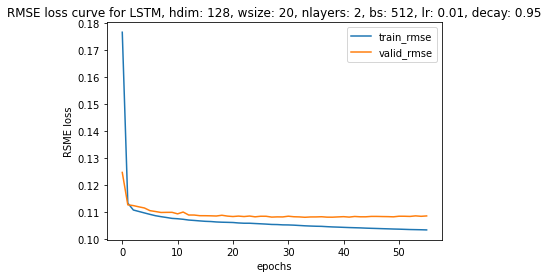

 44%|████▍     | 154/352 [01:51<01:53,  1.75it/s]


 88%|████████▊ | 308/352 [03:37<02:38,  3.60s/it]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343]
0.10853
Epoch 57 | T: 4.64 | Train RMSE: 0.10343 | Valid RMSE: 0.10853


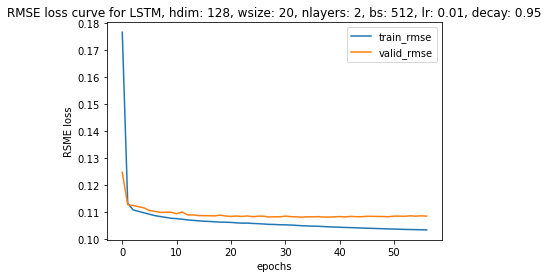

 44%|████▍     | 154/352 [01:42<01:51,  1.78it/s]


 88%|████████▊ | 308/352 [03:27<00:24,  1.78it/s]


100%|██████████| 352/352 [04:07<00:00,  1.42it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338]
0.10872
Epoch 58 | T: 4.66 | Train RMSE: 0.10338 | Valid RMSE: 0.10872


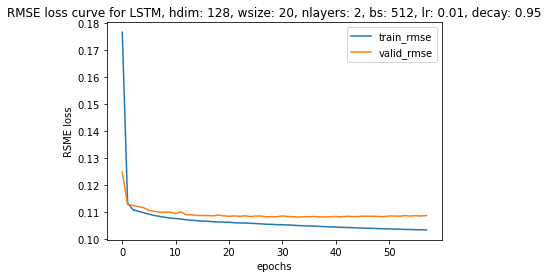

 44%|████▍     | 154/352 [01:44<01:43,  1.92it/s]


 88%|████████▊ | 308/352 [03:32<00:26,  1.68it/s]


100%|██████████| 352/352 [03:58<00:00,  1.48it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334]
0.1087
Epoch 59 | T: 4.63 | Train RMSE: 0.10334 | Valid RMSE: 0.10870


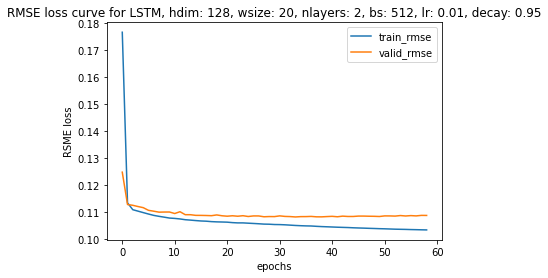

 44%|████▍     | 154/352 [01:52<03:49,  1.16s/it]


 88%|████████▊ | 308/352 [03:39<01:26,  1.96s/it]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331]
0.10862
Epoch 60 | T: 4.50 | Train RMSE: 0.10331 | Valid RMSE: 0.10862


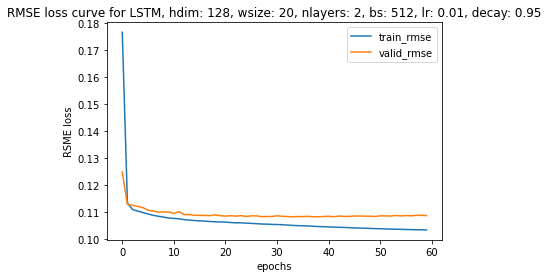

 44%|████▍     | 154/352 [01:54<01:44,  1.89it/s]


 88%|████████▊ | 308/352 [03:33<00:23,  1.87it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325]
0.10866
Epoch 61 | T: 4.54 | Train RMSE: 0.10325 | Valid RMSE: 0.10866


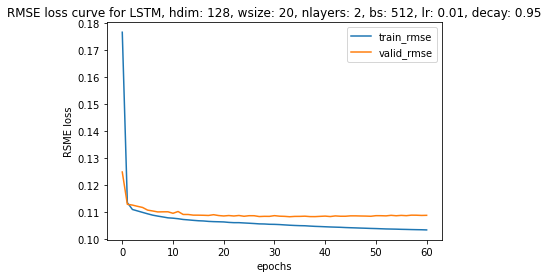

 44%|████▍     | 154/352 [01:54<01:45,  1.88it/s]


 88%|████████▊ | 308/352 [03:22<00:24,  1.82it/s]


100%|██████████| 352/352 [03:55<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032]
0.10871
Epoch 62 | T: 4.34 | Train RMSE: 0.10320 | Valid RMSE: 0.10871


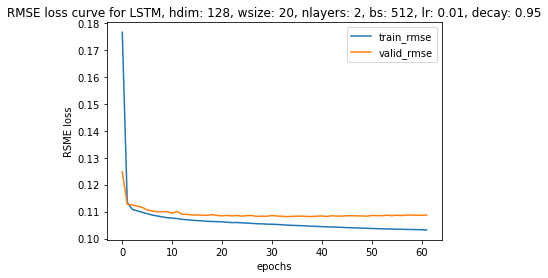

 44%|████▍     | 154/352 [01:53<02:00,  1.65it/s]


 88%|████████▊ | 308/352 [03:33<00:24,  1.80it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317]
0.10875
Epoch 63 | T: 4.69 | Train RMSE: 0.10317 | Valid RMSE: 0.10875


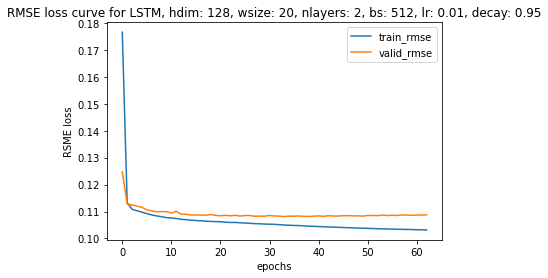

 44%|████▍     | 154/352 [01:48<01:42,  1.92it/s]


 88%|████████▊ | 308/352 [03:22<00:23,  1.91it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314]
0.10862
Epoch 64 | T: 4.41 | Train RMSE: 0.10314 | Valid RMSE: 0.10862


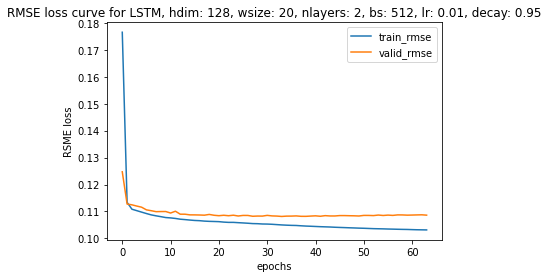

 44%|████▍     | 154/352 [01:47<01:36,  2.06it/s]


 88%|████████▊ | 308/352 [03:34<00:27,  1.59it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031]
0.1087
Epoch 65 | T: 4.70 | Train RMSE: 0.10310 | Valid RMSE: 0.10870


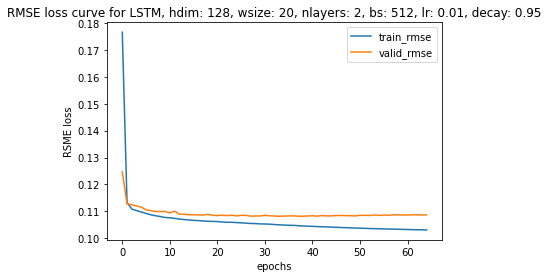

 44%|████▍     | 154/352 [01:45<01:48,  1.82it/s]


 88%|████████▊ | 308/352 [03:17<00:24,  1.83it/s]


100%|██████████| 352/352 [03:51<00:00,  1.52it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307]
0.10879
Epoch 66 | T: 4.32 | Train RMSE: 0.10307 | Valid RMSE: 0.10879


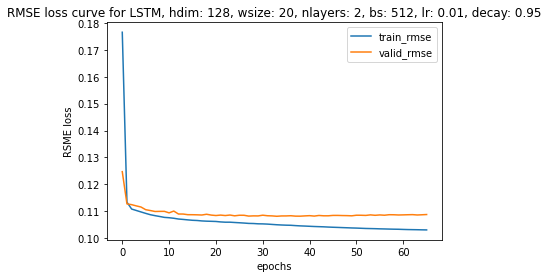

 44%|████▍     | 154/352 [01:51<01:42,  1.93it/s]


 88%|████████▊ | 308/352 [03:37<00:25,  1.72it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304]
0.10879
Epoch 67 | T: 4.66 | Train RMSE: 0.10304 | Valid RMSE: 0.10879


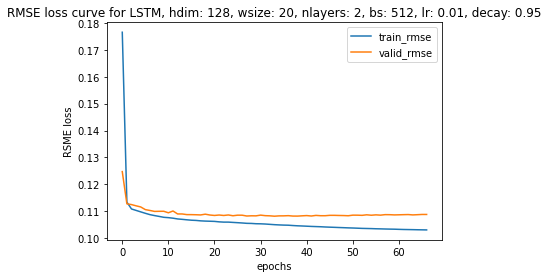

 44%|████▍     | 154/352 [01:52<02:00,  1.64it/s]


 88%|████████▊ | 308/352 [03:38<00:32,  1.37it/s]


100%|██████████| 352/352 [04:05<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302]
0.10883
Epoch 68 | T: 4.74 | Train RMSE: 0.10302 | Valid RMSE: 0.10883


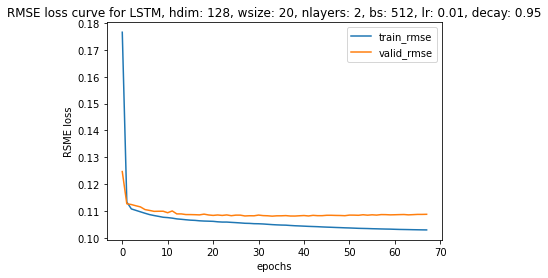

 44%|████▍     | 154/352 [01:53<02:46,  1.19it/s]


 88%|████████▊ | 308/352 [03:24<00:22,  1.96it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298]
0.10882
Epoch 69 | T: 4.51 | Train RMSE: 0.10298 | Valid RMSE: 0.10882


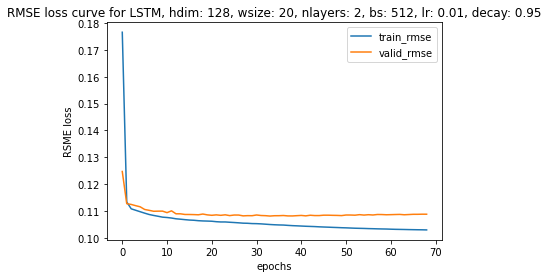

 44%|████▍     | 154/352 [01:51<01:47,  1.84it/s]


 88%|████████▊ | 308/352 [03:35<00:24,  1.79it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296]
0.1088
Epoch 70 | T: 4.71 | Train RMSE: 0.10296 | Valid RMSE: 0.10880


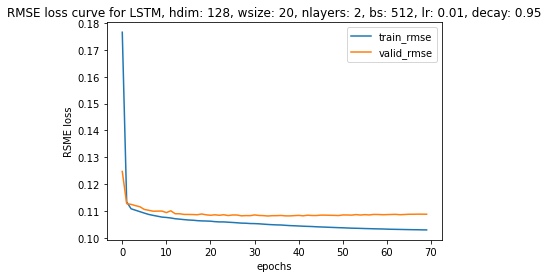

 44%|████▍     | 154/352 [01:46<01:57,  1.69it/s]


 88%|████████▊ | 308/352 [03:22<00:25,  1.72it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294]
0.1089
Epoch 71 | T: 4.46 | Train RMSE: 0.10294 | Valid RMSE: 0.10890


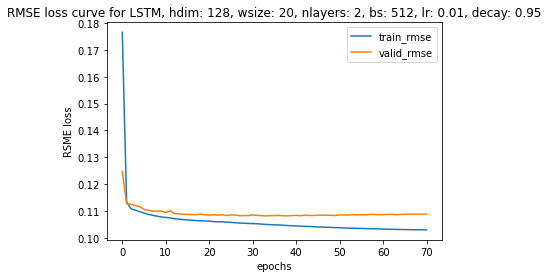

 44%|████▍     | 154/352 [01:57<02:12,  1.50it/s]


 88%|████████▊ | 308/352 [03:42<00:25,  1.72it/s]


100%|██████████| 352/352 [04:17<00:00,  1.37it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291]
0.10885
Epoch 72 | T: 4.74 | Train RMSE: 0.10291 | Valid RMSE: 0.10885


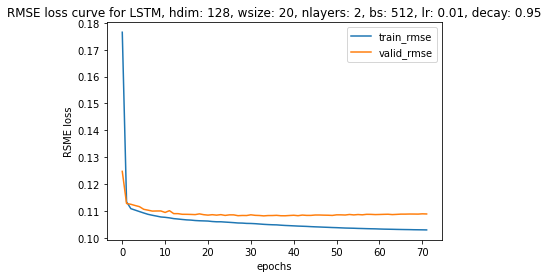

 44%|████▍     | 154/352 [01:50<01:50,  1.80it/s]


 88%|████████▊ | 308/352 [03:33<00:30,  1.46it/s]


100%|██████████| 352/352 [04:01<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288]
0.10891
Epoch 73 | T: 4.69 | Train RMSE: 0.10288 | Valid RMSE: 0.10891


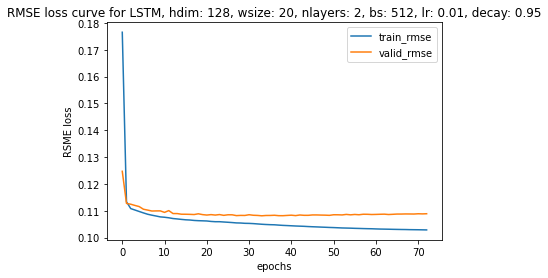

 44%|████▍     | 154/352 [01:54<09:03,  2.74s/it]


 88%|████████▊ | 308/352 [03:30<00:26,  1.69it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288]
0.10898
Epoch 74 | T: 4.53 | Train RMSE: 0.10288 | Valid RMSE: 0.10898


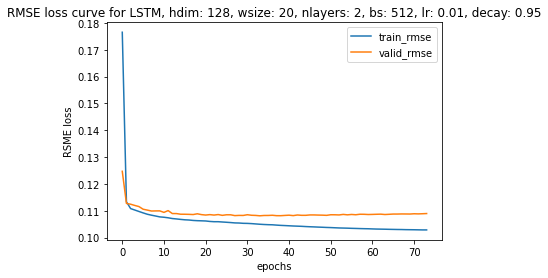

 44%|████▍     | 154/352 [01:51<01:47,  1.83it/s]


 88%|████████▊ | 308/352 [03:35<00:24,  1.79it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286]
0.109
Epoch 75 | T: 4.64 | Train RMSE: 0.10286 | Valid RMSE: 0.10900


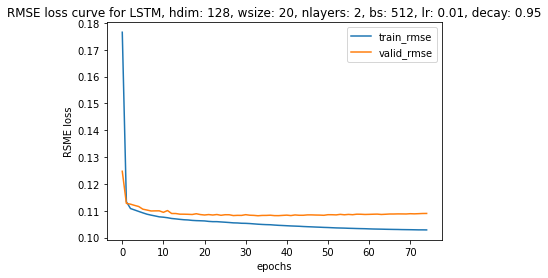

 44%|████▍     | 154/352 [01:54<01:52,  1.76it/s]


 88%|████████▊ | 308/352 [03:27<00:24,  1.78it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284]
0.10892
Epoch 76 | T: 4.73 | Train RMSE: 0.10284 | Valid RMSE: 0.10892


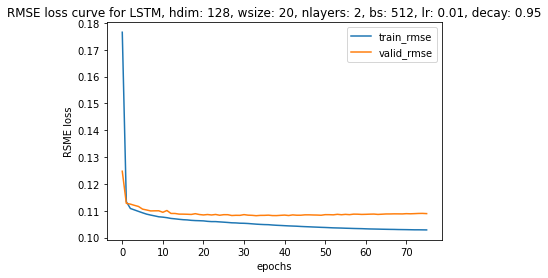

 44%|████▍     | 154/352 [01:36<01:43,  1.91it/s]


 88%|████████▊ | 308/352 [03:26<00:29,  1.51it/s]


100%|██████████| 352/352 [04:03<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028]
0.10895
Epoch 77 | T: 4.51 | Train RMSE: 0.10280 | Valid RMSE: 0.10895


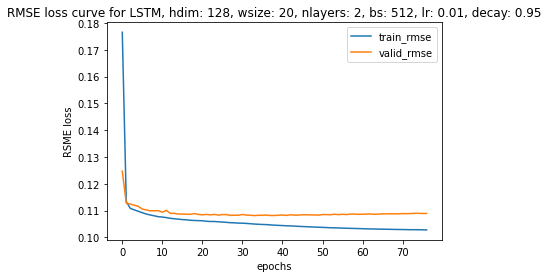

 44%|████▍     | 154/352 [01:49<01:51,  1.77it/s]


 88%|████████▊ | 308/352 [03:33<00:24,  1.76it/s]


100%|██████████| 352/352 [03:58<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278]
0.10895
Epoch 78 | T: 4.65 | Train RMSE: 0.10278 | Valid RMSE: 0.10895


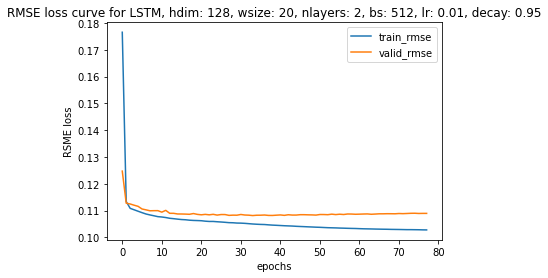

 44%|████▍     | 154/352 [01:53<04:17,  1.30s/it]


 88%|████████▊ | 308/352 [03:29<00:25,  1.73it/s]


100%|██████████| 352/352 [04:04<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276]
0.10897
Epoch 79 | T: 4.53 | Train RMSE: 0.10276 | Valid RMSE: 0.10897


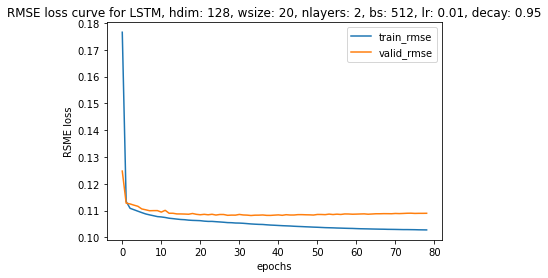

 44%|████▍     | 154/352 [01:52<02:04,  1.59it/s]


 88%|████████▊ | 308/352 [03:37<00:26,  1.68it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278]
0.10905
Epoch 80 | T: 4.67 | Train RMSE: 0.10278 | Valid RMSE: 0.10905


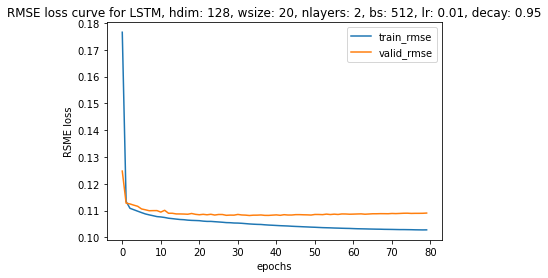

 44%|████▍     | 154/352 [01:57<01:47,  1.84it/s]


 88%|████████▊ | 308/352 [03:42<00:28,  1.56it/s]


100%|██████████| 352/352 [04:08<00:00,  1.41it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273]
0.10902
Epoch 81 | T: 4.82 | Train RMSE: 0.10273 | Valid RMSE: 0.10902


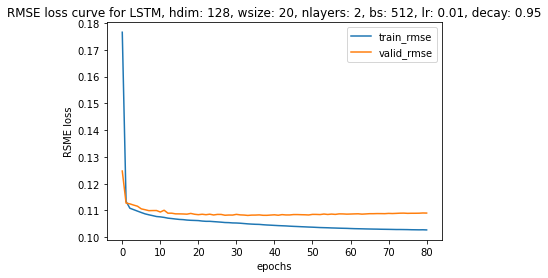

 44%|████▍     | 154/352 [01:51<02:01,  1.63it/s]


 88%|████████▊ | 308/352 [03:28<00:25,  1.70it/s]


100%|██████████| 352/352 [04:05<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271]
0.10907
Epoch 82 | T: 4.55 | Train RMSE: 0.10271 | Valid RMSE: 0.10907


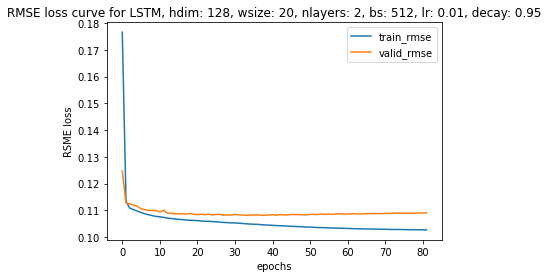

 44%|████▍     | 154/352 [01:55<02:05,  1.57it/s]


 88%|████████▊ | 308/352 [03:45<00:26,  1.68it/s]


100%|██████████| 352/352 [04:18<00:00,  1.36it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027]
0.10908
Epoch 83 | T: 4.78 | Train RMSE: 0.10270 | Valid RMSE: 0.10908


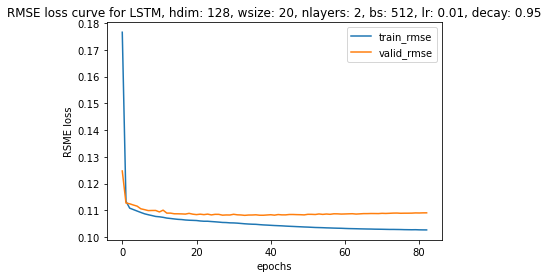

 44%|████▍     | 154/352 [01:50<01:46,  1.86it/s]


 88%|████████▊ | 308/352 [03:39<00:26,  1.68it/s]


100%|██████████| 352/352 [04:03<00:00,  1.44it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269]
0.10902
Epoch 84 | T: 4.69 | Train RMSE: 0.10269 | Valid RMSE: 0.10902


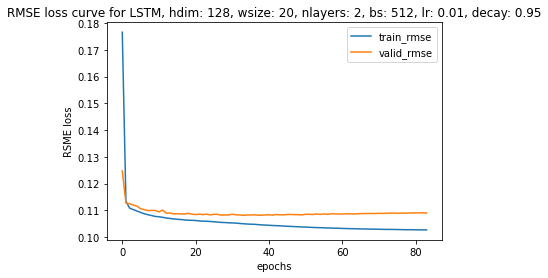

 44%|████▍     | 154/352 [01:48<10:13,  3.10s/it]


 88%|████████▊ | 308/352 [03:22<00:24,  1.83it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267]
0.10908
Epoch 85 | T: 4.37 | Train RMSE: 0.10267 | Valid RMSE: 0.10908


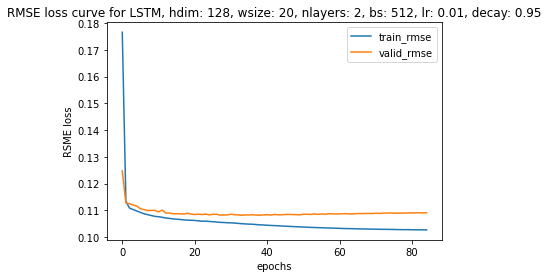

 44%|████▍     | 154/352 [01:57<01:47,  1.84it/s]


 88%|████████▊ | 308/352 [03:43<00:27,  1.58it/s]


100%|██████████| 352/352 [04:11<00:00,  1.40it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266]
0.10913
Epoch 86 | T: 4.82 | Train RMSE: 0.10266 | Valid RMSE: 0.10913


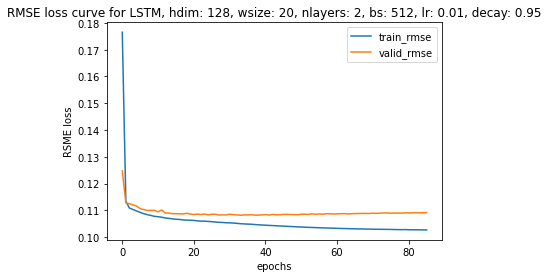

 44%|████▍     | 154/352 [01:50<01:53,  1.75it/s]


 88%|████████▊ | 308/352 [03:23<00:24,  1.83it/s]


100%|██████████| 352/352 [03:57<00:00,  1.48it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266]
0.10917
Epoch 87 | T: 4.41 | Train RMSE: 0.10266 | Valid RMSE: 0.10917


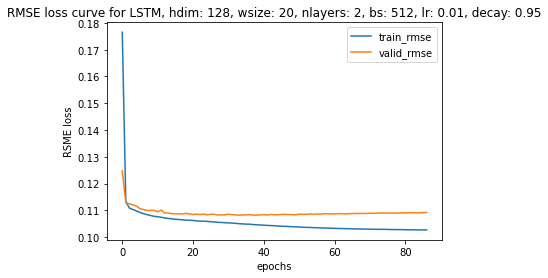

 44%|████▍     | 154/352 [01:57<01:47,  1.85it/s]


 88%|████████▊ | 308/352 [03:37<00:24,  1.77it/s]


100%|██████████| 352/352 [04:14<00:00,  1.39it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264]
0.10911
Epoch 88 | T: 4.67 | Train RMSE: 0.10264 | Valid RMSE: 0.10911


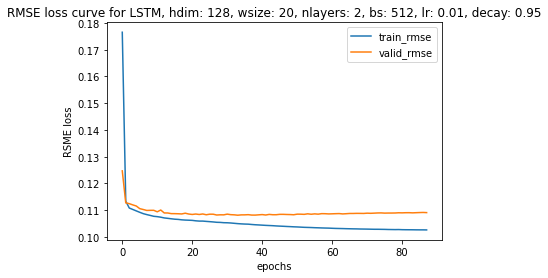

 44%|████▍     | 154/352 [01:48<01:48,  1.83it/s]


 88%|████████▊ | 308/352 [03:20<00:25,  1.75it/s]


100%|██████████| 352/352 [03:59<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264]
0.10912
Epoch 89 | T: 4.61 | Train RMSE: 0.10264 | Valid RMSE: 0.10912


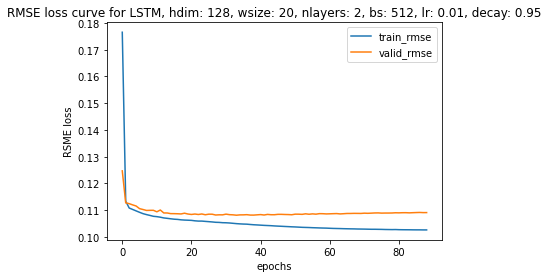

 44%|████▍     | 154/352 [01:40<02:01,  1.63it/s]


 88%|████████▊ | 308/352 [03:30<00:25,  1.69it/s]


100%|██████████| 352/352 [04:06<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261]
0.1092
Epoch 90 | T: 4.61 | Train RMSE: 0.10261 | Valid RMSE: 0.10920


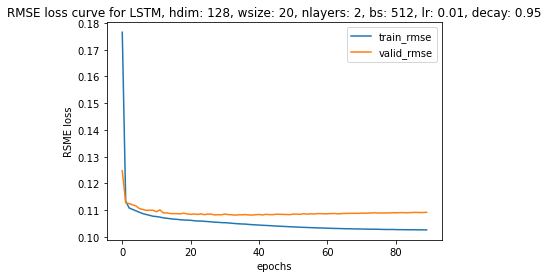

 44%|████▍     | 154/352 [01:53<01:49,  1.81it/s]


 88%|████████▊ | 308/352 [03:44<00:27,  1.60it/s]


100%|██████████| 352/352 [04:18<00:00,  1.36it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261]
0.1092
Epoch 91 | T: 4.81 | Train RMSE: 0.10261 | Valid RMSE: 0.10920


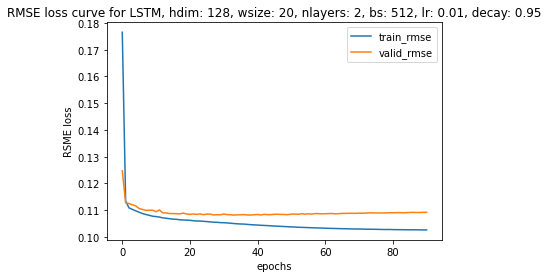

 44%|████▍     | 154/352 [01:51<01:50,  1.80it/s]


 88%|████████▊ | 308/352 [03:41<00:27,  1.62it/s]


100%|██████████| 352/352 [04:08<00:00,  1.42it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262]
0.10917
Epoch 92 | T: 4.79 | Train RMSE: 0.10262 | Valid RMSE: 0.10917


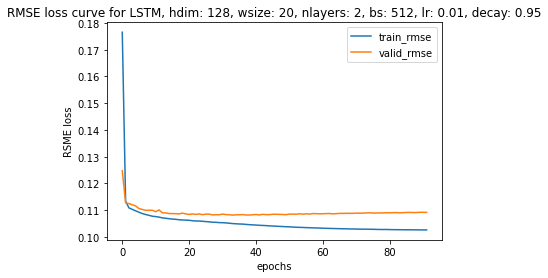

 44%|████▍     | 154/352 [01:53<01:57,  1.68it/s]


 88%|████████▊ | 308/352 [03:26<00:25,  1.71it/s]


100%|██████████| 352/352 [04:02<00:00,  1.45it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259]
0.10924
Epoch 93 | T: 4.49 | Train RMSE: 0.10259 | Valid RMSE: 0.10924


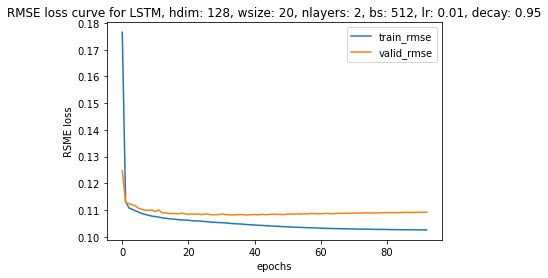

 44%|████▍     | 154/352 [01:50<01:45,  1.88it/s]


 88%|████████▊ | 308/352 [03:32<00:24,  1.82it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258]
0.10921
Epoch 94 | T: 4.67 | Train RMSE: 0.10258 | Valid RMSE: 0.10921


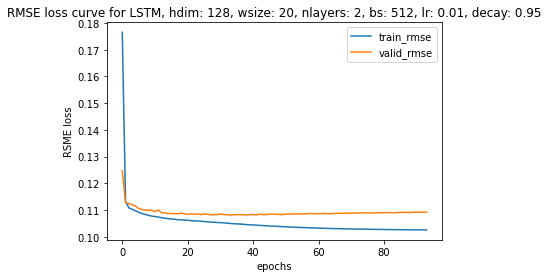

 44%|████▍     | 154/352 [01:47<01:47,  1.84it/s]


 88%|████████▊ | 308/352 [03:20<00:27,  1.60it/s]


100%|██████████| 352/352 [03:56<00:00,  1.49it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257]
0.10923
Epoch 95 | T: 4.62 | Train RMSE: 0.10257 | Valid RMSE: 0.10923


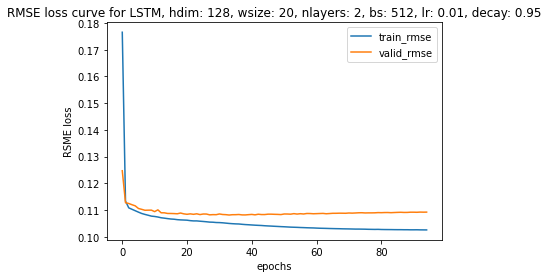

 44%|████▍     | 154/352 [01:39<01:41,  1.95it/s]


 88%|████████▊ | 308/352 [03:30<00:25,  1.71it/s]


100%|██████████| 352/352 [04:05<00:00,  1.43it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257, 0.10257]
0.10925
Epoch 96 | T: 4.56 | Train RMSE: 0.10257 | Valid RMSE: 0.10925


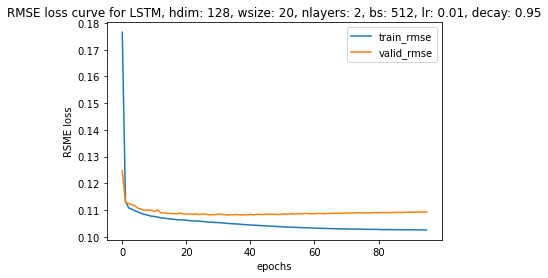

 44%|████▍     | 154/352 [01:47<01:40,  1.98it/s]


 88%|████████▊ | 308/352 [03:29<00:38,  1.15it/s]


100%|██████████| 352/352 [03:53<00:00,  1.50it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257, 0.10257, 0.10257]
0.10919
Epoch 97 | T: 4.52 | Train RMSE: 0.10257 | Valid RMSE: 0.10919


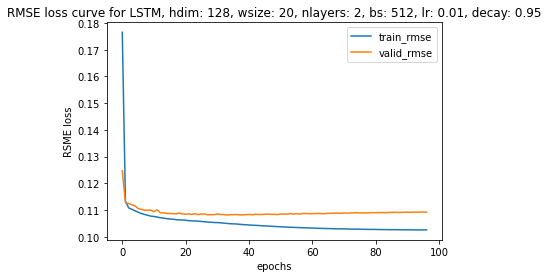

 44%|████▍     | 154/352 [01:42<01:46,  1.85it/s]


 88%|████████▊ | 308/352 [03:25<00:24,  1.80it/s]


100%|██████████| 352/352 [04:00<00:00,  1.47it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257, 0.10257, 0.10257, 0.10255]
0.10926
Epoch 98 | T: 4.44 | Train RMSE: 0.10255 | Valid RMSE: 0.10926


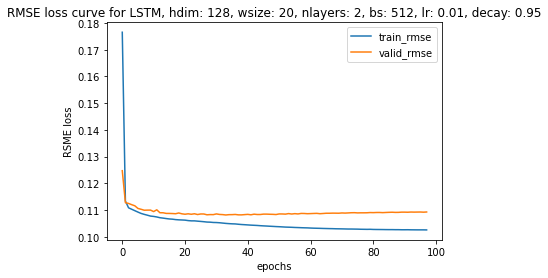

 44%|████▍     | 154/352 [01:50<01:38,  2.01it/s]


 88%|████████▊ | 308/352 [03:19<00:22,  1.97it/s]


100%|██████████| 352/352 [03:52<00:00,  1.51it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257, 0.10257, 0.10257, 0.10255, 0.10254]
0.10925
Epoch 99 | T: 4.29 | Train RMSE: 0.10254 | Valid RMSE: 0.10925


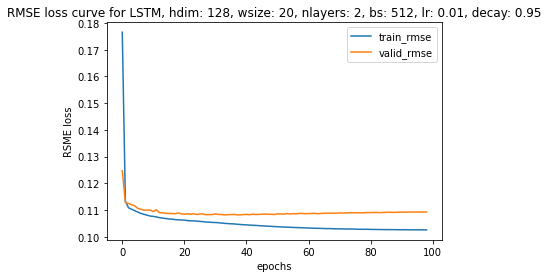

 44%|████▍     | 154/352 [01:58<01:52,  1.76it/s]


 88%|████████▊ | 308/352 [03:42<00:22,  1.96it/s]


100%|██████████| 352/352 [04:16<00:00,  1.37it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257, 0.10257, 0.10257, 0.10255, 0.10254, 0.10254]
0.10928
Epoch 100 | T: 4.74 | Train RMSE: 0.10254 | Valid RMSE: 0.10928


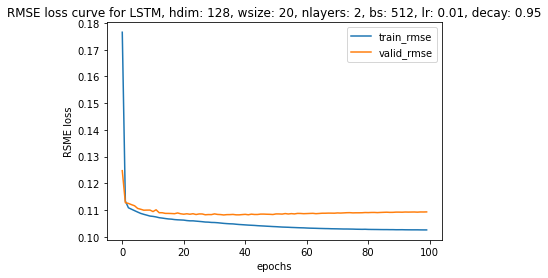

 44%|████▍     | 154/352 [01:51<01:48,  1.82it/s]


 88%|████████▊ | 308/352 [03:37<00:36,  1.21it/s]


100%|██████████| 352/352 [04:00<00:00,  1.46it/s]


[0.17654, 0.11337, 0.11083, 0.11029, 0.10975, 0.10922, 0.10872, 0.10837, 0.10806, 0.10773, 0.1076, 0.1074, 0.10712, 0.10697, 0.1068, 0.10665, 0.10657, 0.10641, 0.10632, 0.10627, 0.10621, 0.10604, 0.10594, 0.10594, 0.10583, 0.10573, 0.10562, 0.10549, 0.10545, 0.10534, 0.10531, 0.10523, 0.10511, 0.10499, 0.1049, 0.10483, 0.10479, 0.10467, 0.10457, 0.1045, 0.10442, 0.10434, 0.10428, 0.10422, 0.10413, 0.10406, 0.104, 0.10393, 0.10387, 0.1038, 0.10375, 0.10368, 0.10361, 0.10357, 0.10353, 0.10347, 0.10343, 0.10338, 0.10334, 0.10331, 0.10325, 0.1032, 0.10317, 0.10314, 0.1031, 0.10307, 0.10304, 0.10302, 0.10298, 0.10296, 0.10294, 0.10291, 0.10288, 0.10288, 0.10286, 0.10284, 0.1028, 0.10278, 0.10276, 0.10278, 0.10273, 0.10271, 0.1027, 0.10269, 0.10267, 0.10266, 0.10266, 0.10264, 0.10264, 0.10261, 0.10261, 0.10262, 0.10259, 0.10258, 0.10257, 0.10257, 0.10257, 0.10255, 0.10254, 0.10254, 0.10253]


 10%|█         | 100/1000 [8:03:52<72:34:52, 290.32s/it]

0.10922


In [64]:
train_rmse = []
valid_rmse = []
min_rmse = 10e8

for i in tqdm(range(num_epoch)):
    start = time.time()

    model.train() # if you use dropout or batchnorm. 
    train_rmse.append(train_epoch(train_loader, model, optimizer, loss_fun))
    print(train_rmse)
    
    model.eval()
    val_rmse = eval_epoch(valid_loader, model, loss_fun)
    valid_rmse.append(val_rmse)
    print(val_rmse)

    # save the best model
    if valid_rmse[-1] < min_rmse:
        min_rmse = valid_rmse[-1] 
        best_model = model
        
        # torch.save([best_model, i, get_lr(optimizer)], name + ".pth")

    end = time.time()
    
    # Early Stopping
    if (len(train_rmse) > 100 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
        torch.save(best_model.state_dict(), f'lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}_epoch_{i+1}.pt')    
        break       

    # Learning Rate Decay        
    scheduler.step()
    
    print("Epoch {} | T: {:0.2f} | Train RMSE: {:0.5f} | Valid RMSE: {:0.5f}".format(i + 1, (end-start) / 60, train_rmse[-1], valid_rmse[-1]))

    plt.figure()
    plt.plot(train_rmse, label="train_rmse")
    plt.plot(valid_rmse, label="valid_rmse")
    plt.xlabel('epochs')
    plt.ylabel('RSME loss')
    plt.title(f'RMSE loss curve for LSTM, hdim: {hidden_dim}, wsize: {window_size}, nlayers: {num_layers}, bs: {batch_size}, lr: {learning_rate}, decay: {decay_rate}')
    plt.legend()
    plt.savefig(f'lstm_loss_curve_v1_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.png')
    plt.show()
    

# Evaluation and Submission

In [25]:
model.load_state_dict(torch.load('lstm_hdim_32_wsize_20_interval_7_nlayers_1_bs_512_lr_0.01_decay_0.95.pt'))
best_model = model

In [65]:
best_model

MyLSTM(
  (lstm): LSTM(4, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
)

In [66]:
test_path = "../val_in/val_in/"
test_pkl_list = glob(os.path.join(test_path, '*'))
test_pkl_list.sort()

test_preds = []
for idx in range(len(test_pkl_list)):
    with open(test_pkl_list[idx], 'rb') as f:
        test_sample = pickle.load(f)
        pred_id = np.where(test_sample["track_id"] == test_sample['agent_id'])[0][0]
        inp_scene = np.dstack([test_sample['p_in'], test_sample['v_in']])

        # Normalization 
        min_vecs = np.min(inp_scene, axis = (0,1))
        max_vecs = np.max(inp_scene, axis = (0,1))
        #print(min_vecs.shape)
        #print(max_vecs.shape)
        
        inp = (inp_scene[pred_id] - min_vecs)/(max_vecs - min_vecs)
        
        inp = torch.from_numpy(inp).float().to(device).unsqueeze(0)

        #print(inp)
        # post-processing for LSTM
        predictions = [[]]
        inp_data = inp[0][-1]
        #print(inp_data.size())
        for i in range(30):
            preds = best_model(inp_data.reshape(1, 1, 4))
            predictions[0].append(preds[0].cpu().data.numpy()[0, :2])
            #print(preds)
            inp_data = preds[0]
            
#         print(inp[0][-1])
#         preds = best_model(inp)#.cpu().data.numpy()
#         print(preds)
#         print(inp.shape)
#         print(preds[0].shape)

        predictions = np.array(predictions)
        #print(predictions.shape)

        # De-Normalization ! 
        predictions = predictions * (max_vecs[:2] - min_vecs[:2]) +  min_vecs[:2]
        test_preds.append(predictions)

In [67]:
print(test_preds[0].shape)
print(test_preds[0])

(1, 30, 2)
[[[1719.4099948   336.36949324]
  [1725.20331361  336.28454933]
  [1731.18027481  336.08865915]
  [1737.28438104  335.81118443]
  [1743.46870725  335.4714306 ]
  [1749.69527642  335.08248608]
  [1755.93245834  334.65360004]
  [1762.15403327  334.19208017]
  [1768.33648664  333.70396898]
  [1774.45859294  333.19495993]
  [1780.5009995   332.67050654]
  [1786.44518599  332.13593142]
  [1792.27408876  331.59644814]
  [1797.97168464  331.05707393]
  [1803.52215851  330.52256425]
  [1808.91240051  329.99732555]
  [1814.12950884  329.48530616]
  [1819.16245456  328.98986545]
  [1824.00187347  328.51368654]
  [1828.6402742   328.05881997]
  [1833.07141396  327.62664   ]
  [1837.29113087  327.21788833]
  [1841.29734401  326.83256494]
  [1845.08838863  326.47021175]
  [1848.6650971   326.12975987]
  [1852.02955035  325.80992226]
  [1855.18507788  325.50908469]
  [1858.13667393  325.22574199]
  [1860.8907894   324.95851988]
  [1863.4559561   324.70658941]]]


# Generate Submission File

### Steps to create submission file 
Run the below cells. The last cell will generate a submission file "test_submission.csv" that you can submit to Kaggle.

In [68]:
# Submission Files
sample_sub = pd.read_csv('sample_submission.csv')

In [71]:
# Save for later use
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)#.astype(int)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv(f'test_submission_lstm_hdim_{hidden_dim}_wsize_{window_size}_interval_{interval}_nlayers_{num_layers}_bs_{batch_size}_lr_{learning_rate}_decay_{decay_rate}.csv', index=None)

In [72]:
# Convert to float
predictions = np.concatenate(test_preds).reshape(len(test_preds), -1)
sub_df = pd.DataFrame(np.c_[sample_sub["ID"], predictions], columns=[np.r_[["ID"], ["v" + str(i) for i in range(1, 61)]]])
sub_df["ID"] = sub_df["ID"].astype(int)
sub_df.to_csv('test_submission.csv', index=None)

In [73]:
sub_df

ID           v1           v2           v3           v4           v5  \
0     10002  1719.409995   336.369493  1725.203314   336.284549  1731.180275   
1     10015   727.496177  1228.487343   729.501623  1227.020683   731.551209   
2     10019   575.937420  1245.525411   577.949851  1246.229434   579.888580   
3     10028  1688.421868   315.642609  1686.011086   315.433464  1683.885100   
4      1003  2124.988001   677.337634  2126.253720   676.509473  2127.818240   
...     ...          ...          ...          ...          ...          ...   
3195   9897   256.107934   806.429025   256.087218   807.626338   256.094916   
3196     99   588.224553  1155.657332   588.625253  1156.738643   589.040805   
3197   9905  1759.557891   444.402348  1763.731861   444.406015  1767.959124   
3198   9910   576.237940  1291.916656   577.363511  1294.875644   578.157823   
3199   9918   587.638949  1166.481728   589.380660  1168.105146   590.439682   

               v6           v7           v8           v9  ...          v51  \
0      336.088659  1737.284381   335.811184  1743.468707  ...  1852.029550   
1     1225.541131   733.649858  1224.036116   735.807510  ...   787.935138   
2     1246.909017   581.766447  1247.556617   583.588199  ...   618.134380   
3      315.277506  1682.060234   315.193592  1680.518450  ...  1658.053798   
4      675.686718  2129.642917   674.856144  2131.708043  ...  2218.717961   
...           ...          ...          ...          ...  ...          ...   
3195   809.096276   256.088205   810.722548   256.036828  ...   240.068192   
3196  1157.748837   589.466163  1158.689328   589.894316  ...   595.922750   
3197   444.195250  1772.224438   443.849696  1776.542309  ...  1866.443332   
3198  1297.933344   578.671536  1301.083615   578.939946  ...   541.070220   
3199  1170.143350   591.029620  1172.422023   591.255681  ...   543.506071   

              v52          v53          v54          v55          v56  \
0      325.809922  1855.185078   325.509085  1858.136674   325.225742   
1     1192.248323   789.823385  1191.082460   791.612788  1189.971742   
2     1208.988457   619.759209  1205.888133   621.359993  1202.839988   
3      317.807724  1656.362865   318.090679  1654.566922   318.396584   
4      644.154731  2224.051100   642.274036  2229.361461   640.417128   
...           ...          ...          ...          ...          ...   
3195   856.978647   238.445174   858.486782   236.737045   859.748825   
3196  1171.919051   596.053556  1172.410363   596.170164  1172.903513   
3197   422.076754  1869.704598   421.300012  1872.801255   420.583009   
3198  1382.560169   537.053684  1384.583994   532.847029  1386.130476   
3199  1214.570876   539.476751  1213.935318   535.429241  1212.952541   

              v57          v58          v59          v60  
0     1860.890789   324.958520  1863.455956   324.706589  
1      793.303437  1188.914976   794.896137  1187.909617  
2      622.930811  1199.866418   624.466382  1196.988248  
3     1652.656799   318.726605  1650.622822   319.082017  
4     2234.624730   638.597277  2239.818130   636.827166  
...           ...          ...          ...          ...  
3195   234.947427   860.738632   233.081285   861.434141  
3196   596.272536  1173.400056   596.360345  1173.901477  
3197  1875.730781   419.922832  1878.491704   419.315732  
3198   528.465023  1387.168444   523.925801  1387.676014  
3199   531.396316  1211.632288   527.412675  1209.989101  

[3200 rows x 61 columns]

In [ ]:
# Ensemble Method 